In [ ]:
import os
import sys
from google.colab import drive 
# Enlazar a la carpeta 'data'
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/ICBF/data')
sys.path.insert(0, '../scripts/0_utils')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ICBF/data


# **Curvas peso-talla**

####**Descripción:**
Genera una tabla de datos con los puntos necesarios para graficar las curvas peso-talla de ambos sexos, para z-scores peso-talla enteros $z$ con $-3 \le z \le 3$.
 
####**Requerimientos:**
- Software en línea [*Anthro Survey Analyser*](https://worldhealthorg.shinyapps.io/anthro/) de la Organización Mundial de la Salud, para el cálculo de z-scores.
 
####**Salidas:**

- Tabla de datos `app/puntos_peso_talla.csv` con los puntos para generar las curvas peso-talla para ambos sexos.

In [ ]:
# Librerias relevantes
import time
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
from scipy.interpolate import interp1d
%matplotlib inline
plt.style.use('ggplot')
 
# Opciones de visualización
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

### **Estimación de la edad a partir de la talla**
Como el software de cálculo de z-scores no admite registros sin edad, se asignará una edad más o menos arbitraria a cada registro. Se utilizará una aproximación simplista a partir de los [gráficos de talla-edad](https://www.who.int/tools/child-growth-standards/standards/length-height-for-age) de la Organización Mundial de la Salud.

In [ ]:
def age_estimated(height):
  '''
  Estima la edad en meses de un niño a partir de su talla en cm, asumiendo una dependencia funcional 
  a trozos con dos trozos lineales, definidos por los puntos:
  (height = 50, age = 0)
  (height = 65, age = 6)
  (height = 110, age= 60)
  '''
  if height < 65:
    age = max((6 / 15) * (height - 50), 0)
  else:
    age = min((54 / 45) * (height - 65) + 6, 59)
  return age

### **Región del espacio peso-talla a muestrear**
Por inspección simple de los [gráficos de peso-talla](https://www.who.int/tools/child-growth-standards/standards/weight-for-length-height) de la Organización Mundial de la Salud, se puede ver que las curvas que necesitamos están acotadas entre las rectas (talla $h$, peso $w$):

- Por abajo, la recta entre los puntos (45 cm, 1 kg) y (110 cm, 13 kg):  $w = (12/65) \cdot (h - 45) + 1$
- Por arriba, la recta entre los puntos (45 cm, 4 kg) y (110 cm, 26 kg):  $w = (22/65) \cdot (h - 45) + 4$


In [ ]:
t0 = time.time()
# Crea un dataframe con 50 puntos igualmente espaceados para cada talla entre las dos rectas
# para cada valor de talla entero en el rango de las gráficas peso-talla
data = pd.DataFrame(columns=['age', 'height', 'weight', 'sex'])
heights = list(range(45, 121))
for sex in ['F', 'M']:
  for h in heights:
    max_weight = (28 / 75) * (h - 45) + 4
    min_weight = (14 / 75) * (h - 45) + 1
    weights = np.linspace(min_weight, max_weight, 100)
    for w in weights:
      data = data.append(pd.DataFrame({'age': [age_estimated(h)],
                                       'height': [h],
                                       'weight': [w],
                                       'sex': [sex]}))
data = data.reset_index(drop=True)
# Guarda el dataframe en un archivo csv
data.to_csv('auxiliary_data/weight_height_curves/region_peso_talla.csv')
data


age height     weight sex
0       0     45   1.000000   F
1       0     45   1.030303   F
2       0     45   1.060606   F
3       0     45   1.090909   F
4       0     45   1.121212   F
...    ..    ...        ...  ..
15195  59    120  31.313131   M
15196  59    120  31.484848   M
15197  59    120  31.656566   M
15198  59    120  31.828283   M
15199  59    120  32.000000   M

[15200 rows x 4 columns]

La tabla de datos generada en formato `csv` debe descargarse e introducirse manualmente en el [*Anthro Survey Analyser*](https://worldhealthorg.shinyapps.io/anthro/), indicando el significado de cada columna. El software calcula los z-scores correspondientes y permite descargar archivos `csv` con un nombre similar al archivo original y el prefijo `_zscore`. El proceso completo tarda unos 5 a 10 minutos.

El archivo con los z-scores debe luego guardarse en el directorio `auxiliary_data/weight_height_curves/`.

In [ ]:
#input("Presiona 'Enter' al terminar de cargar el archivo en el directorio " +
#      "'auxiliary_data/weight_height_curves/': ")

### **Interpolación del peso a partir de sexo, z-scores y talla**

In [ ]:
# Lee la tabla de datos con la relación (talla, peso, sexo, z-score peso/talla)
data_to_fit = pd.read_csv('auxiliary_data/weight_height_curves/region_peso_talla_zscore.csv')
# Conserva los valores de interés con -3 <= z-score peso/talla <= 3
included = data_to_fit['zwfl'].between(-3.2, 3.2)
df = data_to_fit.loc[included, ['height', 'weight', 'sex', 'zwfl']]
df

height     weight sex  zwfl
29         45   1.878788   F -3.14
30         45   1.909091   F -2.95
31         45   1.939394   F -2.76
32         45   1.969697   F -2.57
33         45   2.000000   F -2.39
...       ...        ...  ..   ...
15187     120  29.939394   M  2.95
15188     120  30.111111   M  3.00
15189     120  30.282828   M  3.06
15190     120  30.454545   M  3.12
15191     120  30.626263   M  3.18

[9578 rows x 4 columns]

In [ ]:
# Interpola un valor de peso para valores -3 <= z-score < 3, 45 <= talla <= 120 cm, para cada sexo
zscores = [i - 3 for i in range(7)]
# Crea un arreglo para cada 3-tuplas ('sexo_z-score', talla, peso)
sex_zscore_height_weight = list()
# Para cada sexo, z-score y talla de interés:
for sex in ['F', 'M']:
  for h in heights:  
    # Crea un interpolador a partir de los datos de z-scores y peso conocidos
    weights_z = list()
    x = list(df[(df['height'] == h) & (df['sex'] == sex)]['zwfl'])
    y = list(df[(df['height'] == h) & (df['sex'] == sex)]['weight'])
    interpoler = interp1d(x, y)
    # Crea la 3-tupla ('sex/z-score', talla, peso) y lo agrega a la lista
    for z in zscores:
      sex_zscore_height_weight.append([f'weight_{sex}_{z}', h, float(interpoler(z))])
# Define el orden de las columnas 'sexo_z-score'
cols_ord = [f'weight_{sex}_{z}' for sex in ['F', 'M'] for z in zscores]
# Convierte el arreglo de 3-tuplas en un dataframe y lo desapila (pivot) 
# para dejar una columna por 'sexo_z-score'
points = pd.DataFrame(columns=['sex_z', 'height', 'weight'], data=sex_zscore_height_weight).\
  pivot(index='height', columns='sex_z', values='weight').reset_index()[['height'] + cols_ord]
points

sex_z  height  weight_F_-3  weight_F_-2  weight_F_-1  weight_F_0  weight_F_1  \
0          45     1.901116     2.065954     2.251894    2.461039    2.696970   
1          46     2.032040     2.209127     2.407686    2.630553    2.884613   
2          47     2.162716     2.351460     2.561667    2.801823    3.071358   
3          48     2.296225     2.497065     2.720296    2.973489    3.262088   
4          49     2.436289     2.648271     2.887066    3.155670    3.460018   
5          50     2.586682     2.812374     3.066981    3.351412    3.674860   
6          51     2.750813     2.989043     3.260283    3.563761    3.909495   
7          52     2.925357     3.179419     3.466712    3.792416    4.157466   
8          53     3.110065     3.384057     3.689610    4.033007    4.424353   
9          54     3.305668     3.595909     3.920000    4.287273    4.704132   
10         55     3.508616     3.813782     4.159907    4.550337    4.990303   
11         56     3.713712     4.037749     4.404030    4.816664    5.283946   
12         57     3.918157     4.260779     4.648733    5.083704    5.579475   
13         58     4.122130     4.483810     4.889801    5.350168    5.871407   
14         59     4.325631     4.706840     5.134792    5.613309    6.164848   
15         60     4.526465     4.922145     5.368298    5.873939    6.448081   
16         61     4.720386     5.135623     5.600787    6.125155    6.726020   
17         62     4.912708     5.340298     5.825791    6.372831    6.993251   
18         63     5.096646     5.543896     6.046364    6.614325    7.258047   
19         64     5.278483     5.742056     6.260483    6.849122    7.515811   
20         65     5.458810     5.936649     6.473345    7.082890    7.771268   
21         66     5.632970     6.128254     6.680184    7.309275    8.018855   
22         67     5.805369     6.315960     6.883333    7.527762    8.258007   
23         68     5.976009     6.494722     7.081506    7.744536    8.493887   
24         69     6.138413     6.677265     7.274444    7.958222    8.728889   
25         70     6.301684     6.850409     7.467172    8.160269    8.953610   
26         71     6.459615     7.024926     7.651403    8.367987    9.176236   
27         72     6.619313     7.194372     7.840202    8.565697    9.396768   
28         73     6.772737     7.360356     8.020191    8.764922    9.608741   
29         74     6.928898     7.524652     8.197980    8.962828    9.822103   
30         75     7.074882     7.685859     8.373569    9.150781   10.026487   
31         76     7.218604     7.844890     8.546958    9.333912   10.228358   
32         77     7.366105     7.998260     8.710595    9.519486   10.427714   
33         78     7.510274     8.157951     8.882393    9.700239   10.629697   
34         79     7.661369     8.319824     9.061796    9.895758   10.839865   
35         80     7.931358     8.607407     9.370988   10.229630   11.203292   
36         81     8.098701     8.792448     9.569091   10.449455   11.440000   
37         82     8.271198     8.984315     9.774590   10.672164   11.686988   
38         83     8.453567     9.178403     9.987957   10.907232   11.936956   
39         84     8.643434     9.382284    10.209663   11.145939   12.202783   
40         85     8.836700     9.591871    10.440180   11.395219   12.472428   
41         86     9.029966     9.803926    10.671010   11.644875   12.742492   
42         87     9.223232    10.019176    10.902155   11.895904   13.025140   
43         88     9.420211    10.226149    11.132770   12.145320   13.296251   
44         89     9.609764    10.433121    11.355948   12.396108   13.567782   
45         90     9.803030    10.640093    11.587879   12.647273   13.852525   
46         91     9.996296    10.847066    11.810370   12.895623   14.125103   
47         92    10.181068    11.054038    12.032862   13.138842   14.396448   
48         93    10.374199    11.261010    12.265421   13.390949   14.671515   


### **Gráfica**

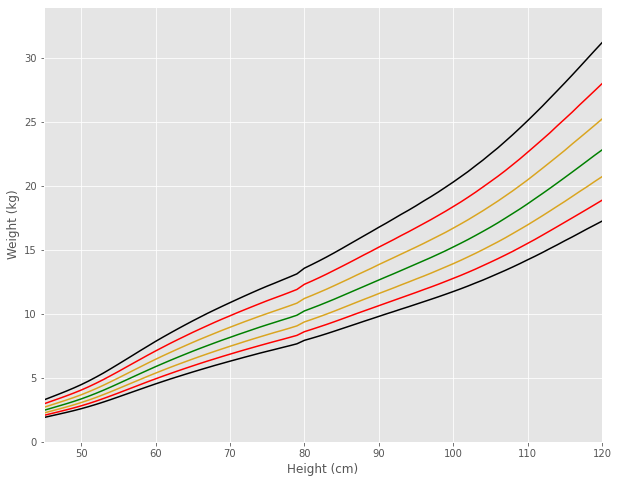

In [ ]:
# Colores y tamaño de la figura
palette = ['black',
           'red',
           'goldenrod',
           'green',
           'goldenrod',
           'red',
           'black']
fig, ax = plt.subplots(figsize=(10, 8))
# Prueba la gráfica completa para el sexo femenino
sex = 'F'
for i, z in enumerate(zscores):
  sns.lineplot(data=points, x='height', y=f'weight_{sex}_{z}', ax=ax, color=palette[i])
ax.set_xlim([45, 120])
ax.set_ylim([0, 34])
ax.set_ylabel('Weight (kg)')
ax.set_xlabel('Height (cm)')
fig.show()

### **Guardado**

In [ ]:
# Guarda la tabla de datos en la carpeta de la aplicación
points.to_csv('app/puntos_peso_talla.csv')
print(f'Archivo guardado: {time.time() - t0:.2f} s.')

Archivo guardado: 51.71 s.
